Lines: [{'id': 0, 'geometry': <LINESTRING (3462.064 1573.692, 3281.49 1573.692)>, 'color': 'blue'}, {'id': 1, 'geometry': <LINESTRING (3462.064 1634.022, 3462.064 1573.692)>, 'color': 'green'}, {'id': 2, 'geometry': <LINESTRING (3293.49 1634.022, 3540.836 1634.022)>, 'color': 'red'}, {'id': 3, 'geometry': <LINESTRING (3517.229 1634.143, 3517.229 1612.14)>, 'color': 'purple'}, {'id': 4, 'geometry': <LINESTRING (3525.049 1634.143, 3525.049 1621.559)>, 'color': 'orange'}]
Intersections: {0: [{'line_id': 1, 'point': (3462.064098031916, 1573.692253005983)}], 1: [{'line_id': 0, 'point': (3462.064098031916, 1573.692253005983)}, {'line_id': 2, 'point': (3462.064098031916, 1634.021738805027)}], 2: [{'line_id': 1, 'point': (3462.064098031916, 1634.021738805027)}, {'line_id': 3, 'point': (3517.229075356232, 1634.021738805027)}, {'line_id': 4, 'point': (3525.048724740528, 1634.021738805027)}], 3: [{'line_id': 2, 'point': (3517.229075356232, 1634.021738805027)}], 4: [{'line_id': 2, 'point': (3525.0

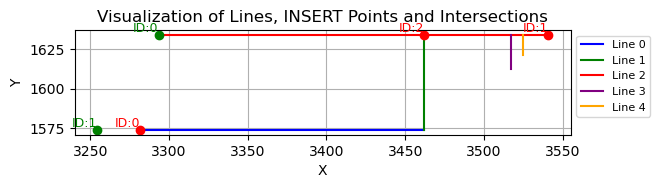

In [8]:
import ezdxf
import matplotlib.pyplot as plt
import math
from shapely.geometry import Point, LineString
import numpy as np

class DXFVisualizer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.doc = ezdxf.readfile(file_path)
        self.msp = self.doc.modelspace()

        # 初始化数据存储
        self.lines = []
        self.insert_points_aa2 = []
        self.insert_points_other = []
        self.intersections = {}
        self.insert_point_closest_line = {}  # 存储 AA2 插入点与最接近的线段的关系

    def read_lines(self):
        """读取所有 LINE 实体并存储"""
        colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'brown', 'pink', 'cyan', 'magenta']  # 预定义颜色
        for idx, entity in enumerate(self.msp.query('LINE')):
            start = (entity.dxf.start.x, entity.dxf.start.y)
            end = (entity.dxf.end.x, entity.dxf.end.y)
            # 为每条线段分配不同的颜色
            color = colors[idx % len(colors)]
            self.lines.append({"id": idx, "geometry": LineString([start, end]), "color": color})
        return self.lines

    def find_intersections(self):
        """查找线段之间的交点"""
        intersections = {line["id"]: [] for line in self.lines}
        for i, line1 in enumerate(self.lines):
            for j, line2 in enumerate(self.lines):
                if i >= j:
                    continue  # 避免重复计算和自交点

                if line1["geometry"].intersects(line2["geometry"]):
                    point = line1["geometry"].intersection(line2["geometry"])
                    if not point.is_empty and point.geom_type == 'Point':
                        intersections[line1["id"]].append({"line_id": line2["id"], "point": (point.x, point.y)})
                        intersections[line2["id"]].append({"line_id": line1["id"], "point": (point.x, point.y)})

        self.intersections = intersections
        return self.intersections

    def read_inserts(self):
        """读取所有 INSERT 实体的插入点，并提取旋转角度"""
        for entity in self.msp:
            if entity.dxftype() == "INSERT":
                insert_point = entity.dxf.insert
                if entity.dxf.name == "AA2":
                    # 获取旋转角度，如果不存在则设为0
                    rotation_angle = getattr(entity.dxf, 'rotation', 0)  # 如果没有旋转角度，默认设为0
                    self.insert_points_aa2.append((insert_point.x, insert_point.y, rotation_angle))
                else:
                    rotation_angle = getattr(entity.dxf, 'rotation', 0)  # 如果没有旋转角度，默认设为0
                    self.insert_points_other.append((insert_point.x, insert_point.y, rotation_angle))
        return self.insert_points_aa2, self.insert_points_other

    @staticmethod
    def line_angle_with_axis(start, end, axis='x'):
        """计算线段与指定轴（x轴或y轴）的夹角"""
        dx = end[0] - start[0]  # 使用索引访问元组元素
        dy = end[1] - start[1]  # 使用索引访问元组元素
        if axis == 'x':
            return math.degrees(math.atan2(dy, dx))
        elif axis == 'y':
            return math.degrees(math.atan2(dx, dy))


    def find_closest_line_for_inserts(self):
        """查找每个 AA2 插入点最接近的线段（支持多个线段）"""
        for idx, point in enumerate(self.insert_points_aa2):
            point_geom = Point(point[0], point[1])
            rotation_angle = point[2]  # 获取旋转角度
            min_distance = float('inf')  # 初始化为一个很大的值
            closest_line_ids = []  # 存储所有最接近的线段 ID
            is_point_on_line = False  # 是否在线段上
    
            # 遍历所有线段，找到距离插入点最近的线段
            for line in self.lines:
                distance = point_geom.distance(line["geometry"])
                if distance < min_distance:
                    min_distance = distance
                    closest_line_ids = [line["id"]]  # 更新最接近的线段 ID 列表
                    # 检查点是否在线段上
                    if distance == 0:
                        is_point_on_line = True
                elif distance == min_distance:
                    closest_line_ids.append(line["id"])  # 如果距离相同，添加到结果列表
    
            # 确定与插入点旋转角度接近的方向
            filtered_line_ids = self.filter_lines_by_rotation(closest_line_ids, rotation_angle)
    
            # 如果找到了符合条件的线段，使用它们
            if filtered_line_ids:
                print(f"插入点 {point} 最接近的线段（根据旋转角度和夹角筛选）: {filtered_line_ids}")
            else:
                print(f"插入点 {point} 找不到符合条件的线段")
    
            # 将筛选后的最接近的线段的 ID 和旋转角度一起记录
            self.insert_point_closest_line[idx] = {
                "line_ids": filtered_line_ids,  # 如果有多个最近的线段，存储所有的线段 ID
                "rotation_angle": rotation_angle,
                "is_point_on_line": is_point_on_line
            }
    
        return self.insert_point_closest_line

    def filter_lines_by_rotation(self, closest_line_ids, rotation_angle):
        """根据旋转角度过滤与坐标轴夹角小于10°的线段"""
        filtered_line_ids = []
        if rotation_angle % 360 < 10 or 170 < rotation_angle % 360 < 190:  # 旋转角度接近 0 或 180
            # 过滤与 x 轴夹角小于 10°的线段
            for line_id in closest_line_ids:
                line = self.lines[line_id]  # 获取线段
                angle = self.line_angle_with_axis(line["geometry"].coords[0], line["geometry"].coords[1], axis='x')
                if abs(angle) < 10 or abs(abs(angle) - 180) < 10:
                    filtered_line_ids.append(line_id)
        elif 80 < rotation_angle % 360 < 100 or 260 < rotation_angle % 360 < 280:  # 旋转角度接近 90 或 270
            # 过滤与 y 轴夹角小于 10°的线段
            for line_id in closest_line_ids:
                line = self.lines[line_id]  # 获取线段
                angle = self.line_angle_with_axis(line["geometry"].coords[0], line["geometry"].coords[1], axis='y')
                if abs(angle) < 10 or abs(abs(angle) - 180) < 10:
                    filtered_line_ids.append(line_id)

        return filtered_line_ids

    def build_line_info_dict(self):
        """通过 Insert Points AA2 Closest Line IDs with Rotation Angles 构建一个新的字典，
           键是 line_id，值是相关信息（如旋转角度、插入点信息等）
        """
        line_info_dict = {}
    
        # 遍历插入点与线段的关系
        for insert_idx, insert_info in self.insert_point_closest_line.items():
            rotation_angle = insert_info["rotation_angle"]
            is_point_on_line = insert_info["is_point_on_line"]
    
            # 遍历每个插入点关联的所有线段
            for line_id in insert_info["line_ids"]:
                if line_id not in line_info_dict:
                    line_info_dict[line_id] = {
                        "rotation_angles": [],  # 存储所有相关的旋转角度
                        "insert_points": [],    # 存储所有相关的插入点坐标
                        "is_point_on_line": is_point_on_line  # 插入点是否在线段上
                    }
    
                # 将该插入点的旋转角度添加到相应的线段信息中
                line_info_dict[line_id]["rotation_angles"].append(rotation_angle)
                line_info_dict[line_id]["insert_points"].append(self.insert_points_aa2[insert_idx])  # 使用插入点的坐标

        return line_info_dict

    def visualize(self):
        """可视化所有图形：线段、插入点和交点"""
        fig, ax = plt.subplots()

        # 绘制线段，每条线段用不同颜色
        for line in self.lines:
            x, y = line["geometry"].xy
            ax.plot(x, y, label=f'Line {line["id"]}', color=line["color"])

        # 绘制 AA2 块插入点，并标记 ID
        for idx, point in enumerate(self.insert_points_aa2):
            ax.plot(point[0], point[1], 'ro')  # 红色圆点
            ax.text(point[0], point[1], f"ID:{idx}", fontsize=9, color="red", verticalalignment="bottom", horizontalalignment="right")

        # 绘制其他块的插入点，并标记 ID
        for idx, point in enumerate(self.insert_points_other):
            ax.plot(point[0], point[1], 'go')  # 绿色圆点
            ax.text(point[0], point[1], f"ID:{idx}", fontsize=9, color="green", verticalalignment="bottom", horizontalalignment="right")

        # # 绘制交点
        # for line_id, intersected in self.intersections.items():
        #     for entry in intersected:
        #         point = entry["point"]
        #         ax.plot(point[0], point[1], 'ko')  # 黑色圆点表示交点

        ax.set_aspect('equal')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Visualization of Lines, INSERT Points and Intersections')
    
        # 设置图例位置为最右边
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
        plt.grid(True)
        plt.show()

# 使用示例
file_path = "../../Drawing0.dxf"  # 替换为你的 DXF 文件路径

# 创建对象
visualizer = DXFVisualizer(file_path)

# 获取线段数据
lines = visualizer.read_lines()
print("Lines:", lines)

# 查找交点
intersections = visualizer.find_intersections()
print("Intersections:", intersections)

# 获取插入点数据
insert_points_aa2, insert_points_other = visualizer.read_inserts()
print("Insert Points AA2:", insert_points_aa2)
print("Insert Points Other:", insert_points_other)

# 查找每个 AA2 插入点最接近的直线
insert_point_closest_line = visualizer.find_closest_line_for_inserts()
print("Insert Points AA2 Closest Line IDs with Rotation Angles:", insert_point_closest_line)

# 构建线段信息字典
line_info_dict = visualizer.build_line_info_dict()

# 打印结果
print(line_info_dict)

# 可视化图形
visualizer.visualize()

###箭头 0°是左  90°是下